In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

In [79]:
train = pd.read_csv('data/train.csv')

In [80]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [82]:
train.isna().sum() / len(train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [83]:
round(train.isna().sum() / len(train), 4) * 100

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [84]:
[(i, train[i].unique()) if train[i].nunique() <= 10 else (i, train[i].nunique()) for i in train.columns]

[('PassengerId', 891),
 ('Survived', array([0, 1], dtype=int64)),
 ('Pclass', array([3, 1, 2], dtype=int64)),
 ('Name', 891),
 ('Sex', array(['male', 'female'], dtype=object)),
 ('Age', 88),
 ('SibSp', array([1, 0, 3, 4, 2, 5, 8], dtype=int64)),
 ('Parch', array([0, 1, 2, 5, 3, 4, 6], dtype=int64)),
 ('Ticket', 681),
 ('Fare', 248),
 ('Cabin', 147),
 ('Embarked', array(['S', 'C', 'Q', nan], dtype=object))]

<Axes: xlabel='Cabin'>

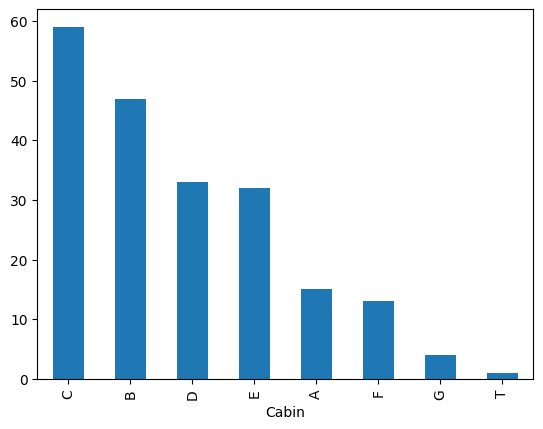

In [85]:
train.Cabin.str[0].value_counts().plot(kind='bar')

<Axes: xlabel='Ticket', ylabel='count'>

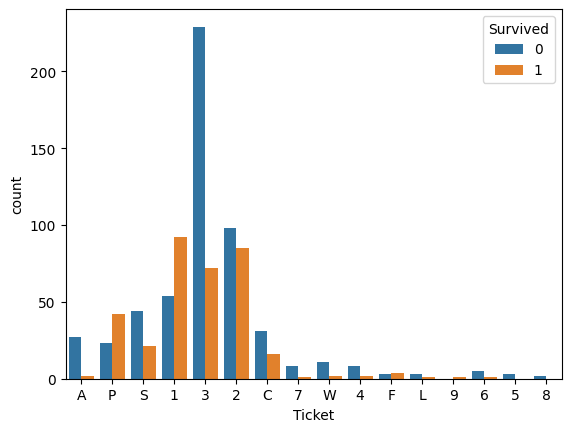

In [86]:
sns.countplot(train, x=train.Ticket.str[0], hue=train.Survived)

In [87]:
X_train = train.drop('Survived', axis=1)
y_train = train.Survived

In [88]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [89]:
class modifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        X_new['Cabin'] = X_new.Cabin.str[0]
        X_new['Ticket'] = X_new.Ticket.str[0]

        salute = ['Sir. ', 'Miss. ', 'Mr. ', 'Mrs. ']

        for i in salute:
            X_new[i] = X_new.Name.str.contains(i) == True

        X_new.drop(['PassengerId', 'Name'], axis=1, inplace=True)
        
        return X_new

In [90]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])

In [91]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [92]:
numerical_cols = ['Age', 'Fare']  
categorical_cols = ['Pclass', 'Sex', 'SibSp', 'Ticket', 'Parch', 'Cabin', 'Embarked']

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols), 
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

In [94]:
pipeline = Pipeline([
    ('modifyColumns', modifyColumns()),
    ('preprocessor', preprocessor),
    ('clf', SVC())
])

In [95]:
modifyColumns().transform(X_train)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sir.,Miss.,Mr.,Mrs.
0,3,male,22.0,1,0,A,7.2500,NaN,S,False,False,True,False
1,1,female,38.0,1,0,P,71.2833,C,C,False,False,False,True
2,3,female,26.0,0,0,S,7.9250,NaN,S,False,True,False,False
3,1,female,35.0,1,0,1,53.1000,C,S,False,False,False,True
4,3,male,35.0,0,0,3,8.0500,NaN,S,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,2,13.0000,NaN,S,False,False,False,False
887,1,female,19.0,0,0,1,30.0000,B,S,False,True,False,False
888,3,female,NaN,1,2,W,23.4500,NaN,S,False,True,False,False
889,1,male,26.0,0,0,1,30.0000,C,C,False,False,True,False


In [96]:
param_grid = {'clf': [CatBoostClassifier(), SVC(), RandomForestClassifier()]}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Learning rate set to 0.009807
0:	learn: 0.6882523	total: 2.74ms	remaining: 2.74s
1:	learn: 0.6821219	total: 6.91ms	remaining: 3.45s
2:	learn: 0.6754021	total: 11.3ms	remaining: 3.77s
3:	learn: 0.6695568	total: 16ms	remaining: 3.97s
4:	learn: 0.6634291	total: 20.1ms	remaining: 3.99s
5:	learn: 0.6570658	total: 24.6ms	remaining: 4.08s
6:	learn: 0.6515036	total: 29.6ms	remaining: 4.2s
7:	learn: 0.6453288	total: 34.1ms	remaining: 4.22s
8:	learn: 0.6408424	total: 38.7ms	remaining: 4.26s
9:	learn: 0.6362182	total: 43.2ms	remaining: 4.28s
10:	learn: 0.6308325	total: 48.9ms	remaining: 4.4s
11:	learn: 0.6268318	total: 52.9ms	remaining: 4.36s
12:	learn: 0.6229345	total: 57.3ms	remaining: 4.35s
13:	learn: 0.6179830	total: 61.6ms	remaining: 4.34s
14:	learn: 0.6136525	total: 66.5ms	remaining: 4.36s
15:	learn: 0.6094966	total: 70.2ms	remaining: 4.32s
16:	learn: 0.6044901	total: 75ms	remaining: 4.34s
17:	learn: 0.6006078	total: 80.5ms	remaining: 4.39s
18:	learn: 0.5957089	total: 85.4ms	remaining: 4.41

In [97]:
test = pd.read_csv('data/test.csv')

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [99]:
best_model = grid_search.best_estimator_

y_test = best_model.predict(test)

print("Predictions: ", y_test)

Predictions:  [0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [100]:
result = pd.DataFrame(y_test, columns=['Survived'])

In [101]:
test.join(result)[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)